In [1]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

from deg.gradient_extimation import FeatureExtractor
from loss.deg_loss import Loss
from corruption.noise import gaussian
from Utils.visualize import visualize

In [2]:
Loss.info()

Avalible Loss: ['R2', 'KL Divergence', 'MSE', 'Chi Squared', 'Canberra Distance', 'Jenson Distance', 'AOC']


Text(0.5, 1.0, 'Noisy Lena')

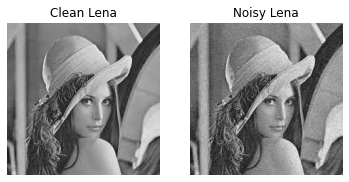

In [3]:
img = cv2.imread("image/lena512.jpg", 0)
img_noise = gaussian(img, 0, 10)

f, ax = plt.subplots(1,2)
ax[0].imshow(img, cmap="gray")
ax[0].set_axis_off()
ax[0].set_title("Clean Lena")
ax[1].imshow(img_noise, cmap="gray")
ax[1].set_axis_off()
ax[1].set_title("Noisy Lena")

In [4]:
backbone = FeatureExtractor(gaussian)
loss = Loss()

img = torch.tensor(img)
img_noise = torch.tensor(img_noise)

p = backbone(img, img_noise)
l = loss(*p)
print(l)

tensor(397.3363)


c:\Users\imsin\Desktop\deg\Utils\utils.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img, dtype=torch.int32)


# Visualize DE-G

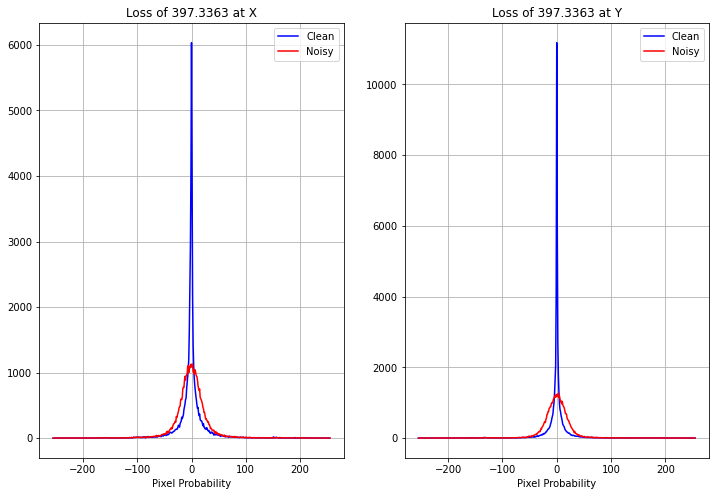

In [5]:
visualize(*p, title="Loss of "+str(round(l.item(),4)))

# Noise Model's Parameter Estimation

In [6]:
var = 5
img_query = gaussian(img, 0, var)

